In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import random
import json
import gc

import numpy as np
import pandas as pd
import torch
import torchio as tio
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from research.data.natural_scenes import NaturalScenesDataset
from research.experiments.nsd_access import NSDAccess
from research.metrics.metrics import cosine_distance, top_knn_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nsd_path = Path('D:\\Datasets\\NSD\\')
nsd = NaturalScenesDataset(nsd_path)

In [ ]:
# Option 1: Compare an embedding to itself
model_name = 'ViT-B=32'
stimulus_key = 'embedding'

save_key = stimulus_key
save_model_name = model_name

stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{model_name}.hdf5', 'r')
x = torch.from_numpy(stimulus_file[stimulus_key][:]).cuda()
x = y

In [16]:
# Option 2: Compare an embedding to another embedding

x_model_name = 'ViT-B=32'
x_stimulus_key = 'embedding'

y_model_name = 'ViT-B=32-text'
y_stimulus_key = 'embedding_mean'

save_model_name = f'{x_model_name}__{y_model_name}'
save_key = f'{x_stimulus_key}__{y_stimulus_key}'

x_stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{x_model_name}.hdf5', 'r')
x = torch.from_numpy(x_stimulus_file[x_stimulus_key][:]).cuda().float()

y_stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{y_model_name}.hdf5', 'r')
y = torch.from_numpy(y_stimulus_file[y_stimulus_key][:]).cuda().float()

In [ ]:
# Run the option

N = x.shape[0]
rsm_path = nsd_path / f'derivatives/stimulus_embeddings/distance_matrix/{save_model_name}.hdf5'
with h5py.File(rsm_path, 'a') as f:
    f.require_dataset(save_key, shape=(N, N), dtype='f4')
    
    for i in tqdm(range(N)):
        distances = cosine_distance(x[i, None], y).cpu().numpy()
        f[save_key][i] = distances


In [ ]:
# Get 2v2 accuracy

model_name = 'ViT-B=32__ViT-B=32-text'
embedding_name = 'embedding__embedding_mean'

distance_path = nsd_path / f'derivatives/stimulus_embeddings/distance_matrix/{model_name}.hdf5'
distance_file = h5py.File(distance_path, 'r')
print(list(distance_file.keys()))
d = distance_file[embedding_name][:]
N = d.shape[0]

In [ ]:
N * (N - 1) // 2

In [ ]:
passed = np.array([0], dtype=np.int64)
total = N * (N - 1) // 2

diag = np.diag(d)
for i in tqdm(range(N)):
    s1 = diag[i]
    j = i + 1
    s2 = diag[j:]
    d1 = d[i, j:]
    d2 = d[j:, i]
    passed += ((s1 + s2) < (d1 + d2)).sum()
acc_2v2 = passed / total

In [ ]:
print(passed, total) #[2664086913] 2664463500
print(total - passed) #[376587]

In [89]:
2664086913 / 2664463500

0.9998586631042234

In [44]:
for some_k in np.arange(1, 5):
    print(type(int(some_k)))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [48]:
from pipeline.utils import nested_insert, is_sequence
is_sequence(np.arange(10))

False

In [79]:
# Top k accuracy
k=np.arange(1, 1001)
top_k_accuracy = top_knn_test(x, y, k=np.arange(1, 1001), metric='cosine')

[0.1763013698630137, 0.24409589041095892, 0.2899041095890411, 0.32282191780821917, 0.35004109589041094, 0.3720821917808219, 0.3924109589041096, 0.4087945205479452, 0.42434246575342466, 0.4383013698630137, 0.4513013698630137, 0.4623150684931507, 0.4728904109589041, 0.4832191780821918, 0.4927808219178082, 0.5019178082191781, 0.5101917808219179, 0.5182191780821918, 0.5252876712328767, 0.5324794520547945, 0.539, 0.5458493150684931, 0.552068493150685, 0.5583561643835616, 0.5641917808219178, 0.5694794520547946, 0.5742739726027397, 0.5795890410958904, 0.585013698630137, 0.5895068493150685, 0.5948493150684931, 0.5995616438356164, 0.603972602739726, 0.6083698630136987, 0.6122602739726027, 0.6162465753424657, 0.6198082191780822, 0.6235890410958904, 0.6272054794520548, 0.6308493150684932, 0.6345616438356164, 0.638, 0.6411780821917809, 0.6446027397260274, 0.6475342465753424, 0.6504109589041096, 0.6536027397260274, 0.6566712328767124, 0.6595616438356164, 0.6624246575342466, 0.6652876712328767, 0.66

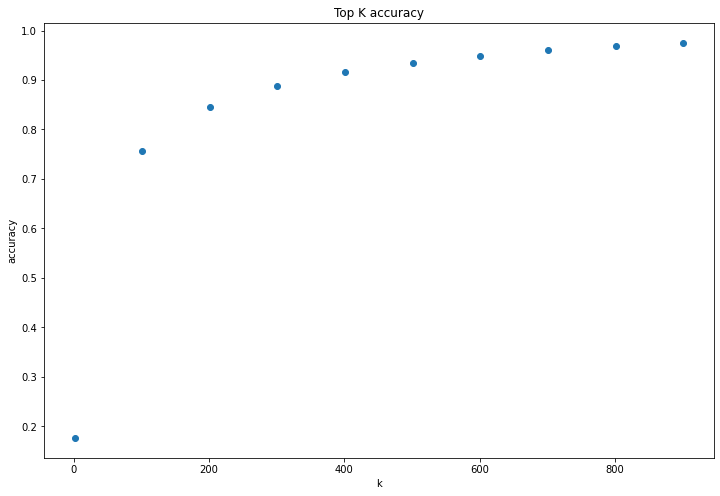

In [96]:
k=np.arange(1, 1001)
plt.figure(figsize=(12, 8))
plt.scatter(k[::100], np.array(top_k_accuracy)[::100])
plt.title('Top K accuracy')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

In [105]:
steps = [0, 4, 9, 24, 49, 99, 249, 499, 999]
for i in steps:
    print(f'k={k[i]}, accuracy={round(top_k_accuracy[i] * 100., 1)}%')

k=1, accuracy=17.6%
k=5, accuracy=35.0%
k=10, accuracy=43.8%
k=25, accuracy=56.4%
k=50, accuracy=66.2%
k=100, accuracy=75.6%
k=250, accuracy=86.9%
k=500, accuracy=93.5%
k=1000, accuracy=98.1%


In [20]:
neighbors = NearestNeighbors(metric='cosine')
neighbors.fit(x.cpu().numpy())

NearestNeighbors(metric='cosine')

In [23]:
distances, ids = neighbors.kneighbors(y.cpu().numpy(), n_neighbors=5)

In [40]:
k = [1, 2, 3, 4, 5]
target_ids = np.arange(ids.shape[0])[:, None]
accuracy = [
    np.any(ids[:, :some_k] == target_ids, axis=1).mean()
    for some_k in k
]
accuracy

[0.1763013698630137,
 0.24409589041095892,
 0.2899041095890411,
 0.32282191780821917,
 0.35004109589041094]

In [35]:
np.max([1, 2, 3, 4])

4

In [34]:
np.all(distances[:, 3] <= distances[:, 4])

True

In [3]:
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)

model_name = 'ViT-B=32-text'
stimulus_key = 'embedding_mean'

save_key = stimulus_key
save_model_name = model_name

stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{model_name}.hdf5', 'r')
x = stimulus_file[stimulus_key][:]

In [4]:
tsne = TSNE(
    n_components=2, 
    metric='cosine', 
    init="pca", 
    #learning_rate="auto", 
    random_state=0,
    verbose=10,
)
tsne.fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 73000 samples in 0.029s...
[t-SNE] Computed neighbors for 73000 samples in 78.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 73000
[t-SNE] Computed conditional probabilities for sample 2000 / 73000
[t-SNE] Computed conditional probabilities for sample 3000 / 73000
[t-SNE] Computed conditional probabilities for sample 4000 / 73000
[t-SNE] Computed conditional probabilities for sample 5000 / 73000
[t-SNE] Computed conditional probabilities for sample 6000 / 73000
[t-SNE] Computed conditional probabilities for sample 7000 / 73000
[t-SNE] Computed conditional probabilities for sample 8000 / 73000
[t-SNE] Computed conditional probabilities for sample 9000 / 73000
[t-SNE] Computed conditional probabilities for sample 10000 / 73000
[t-SNE] Computed conditional probabilities for sample 11000 / 73000
[t-SNE] Computed conditional probabilities for sample 12000 / 73000
[t-SNE] Computed conditional probabilities for sa

array([[ 38.417496 ,  -1.7228161],
       [-51.37391  ,  21.785172 ],
       [ -2.0054584, -51.17078  ],
       ...,
       [ 21.804607 ,  52.252426 ],
       [-22.121574 , -14.421277 ],
       [-11.717109 ,  27.013088 ]], dtype=float32)

[autoreload of research.metrics.metrics failed: Traceback (most recent call last):
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 

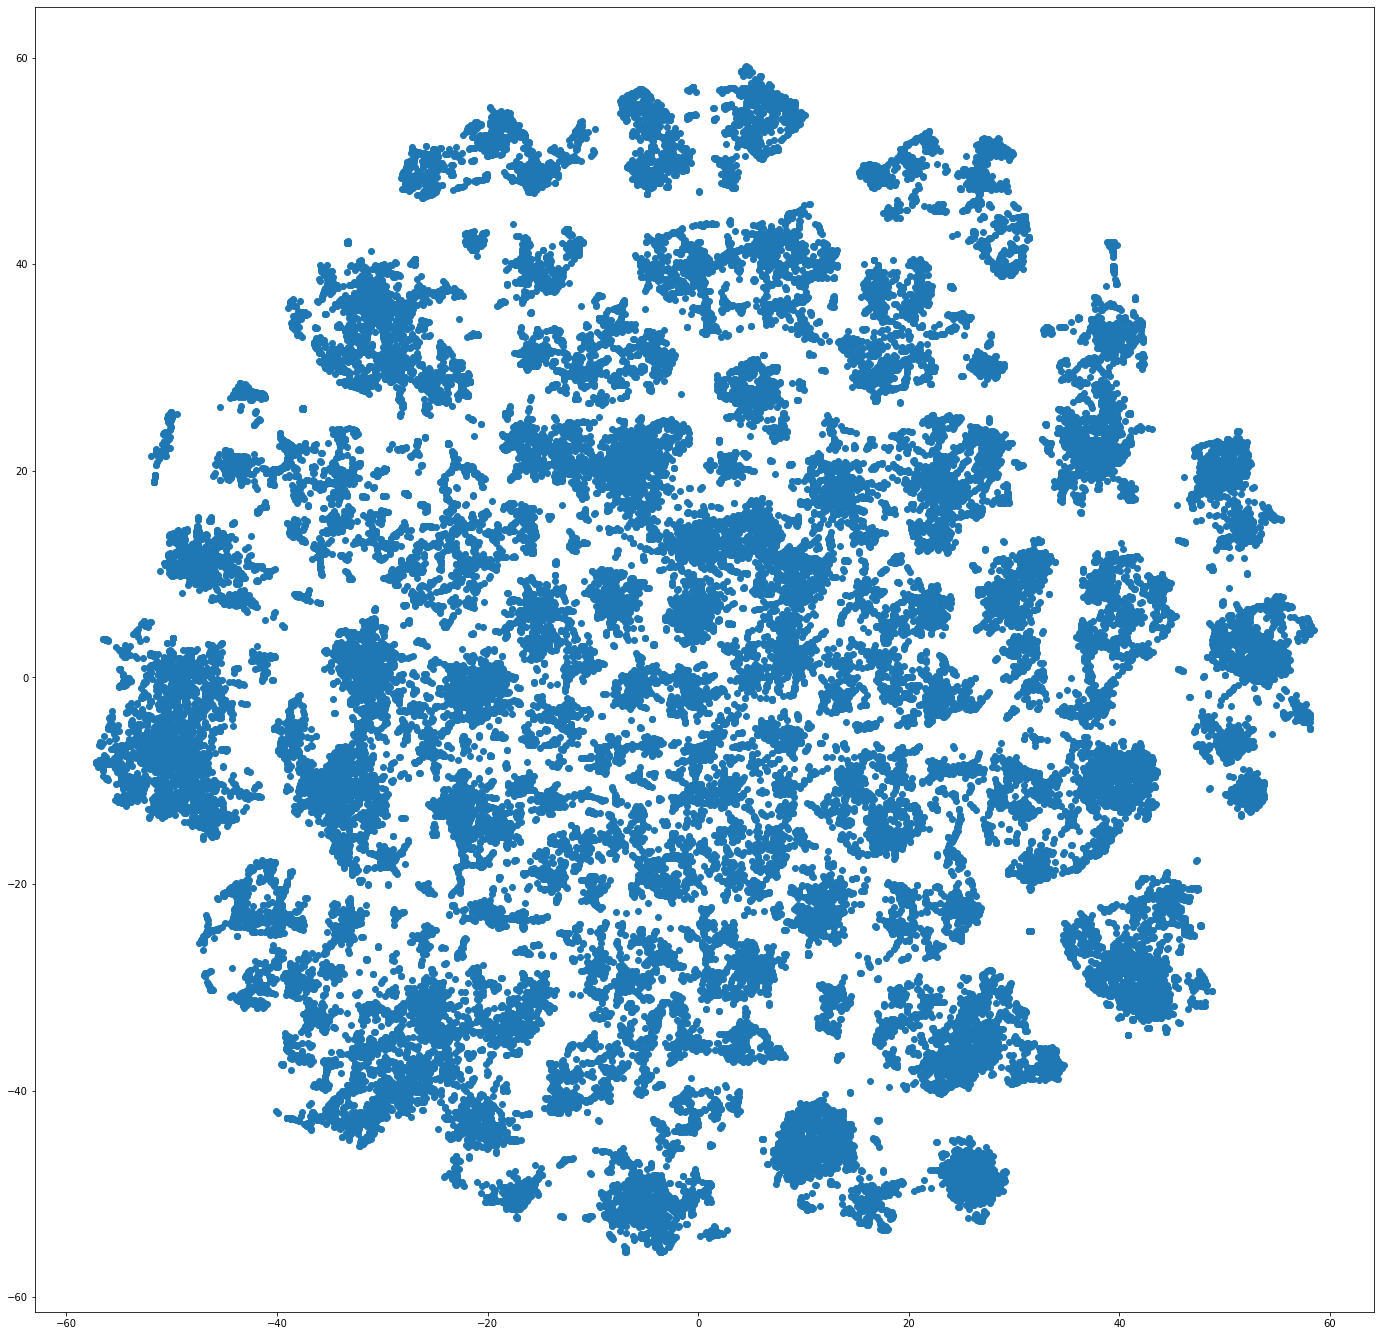

In [5]:
y = tsne.embedding_
plt.figure(figsize=(24, 24))
plt.scatter(y[:, 0], y[:, 1])
plt.show()


In [6]:
stimuli_path = nsd_path / 'nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimuli_path, 'r')['imgBrick']

image_size = 64
num_images = 400
S = image_size * num_images
full_image = np.zeros(shape=(S, S, 3), dtype=np.ubyte)

In [7]:
extent = 60
coords = np.linspace(-extent, extent, num_images)
grid = np.stack(np.meshgrid(coords, coords))
grid = rearrange(grid, 'd h w -> (h w) d')
grid.shape

(160000, 2)

In [8]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(metric='chebyshev')
neighbors.fit(y)

distances, ids = neighbors.kneighbors(grid, n_neighbors=1,)
distances = rearrange(distances, '(h w) d -> h w d', h=num_images)
ids = rearrange(ids, '(h w) d -> h w d', h=num_images)

In [13]:
ids.shape

(400, 400, 1)

In [9]:
import PIL
from PIL import Image

neighbors = NearestNeighbors(metric=metric)

distance_threshold = extent / num_images
for i in tqdm(range(num_images)):
    for j in range(num_images):
        if distances[i, j] > distance_threshold:
            continue
        stimulus_id = ids[i, j, 0]
        stim_image = stimulus_images[stimulus_id]
        stim_image = Image.fromarray(stim_image)
        stim_image = stim_image.resize(size=(image_size, image_size), resample=PIL.Image.LANCZOS)
        stim_image = np.array(stim_image)
        full_image[i * image_size:(i + 1) * image_size, j * image_size:(j + 1) * image_size] = stim_image

  0%|          | 0/400 [00:00<?, ?it/s]

In [10]:
out_path = nsd_path / 'derivatives/cluster'
Image.fromarray(full_image).save(out_path / f'{model_name}__{stimulus_key}.png')

[autoreload of research.metrics.metrics failed: Traceback (most recent call last):
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Cefir\anaconda3\envs\Neurophysiological-Data-Decoding\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "G:\Github Repositories\Neurophysiologi

In [119]:
nsd_path = Path('D:\\Datasets\\NSD\\')
nsd = NaturalScenesDataset(nsd_path, coco_path='X:\\Datasets\\COCO')

In [140]:
reconstructions_path = nsd_path / 'derivatives/reconstructions/ViT-B=32/group-1/subj01/aee0d0f6/images'
reconstruction_files = [p for p in reconstructions_path.iterdir()]

stimulu_path = nsd_path / 'nsddata_stimuli' / 'stimuli' / 'nsd' / 'nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimulu_path, 'r')['imgBrick']

@interact(i=(0, len(reconstruction_files)))
def show(i):
    recon_file = reconstruction_files[i]
    reconstruction_img = np.array(Image.open(recon_file))
    
    stim_id = int(recon_file.name.split('_')[1].split('-')[1])
    
    ground_truth_img = np.array(Image.fromarray(stimulus_images[stim_id]).resize((224, 224)))
    img = np.concatenate([ground_truth_img, reconstruction_img], axis=1)
    captions = nsd.load_coco(stim_id)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()
    
    print('TRUE:')
    for c in captions:
        print(c)

interactive(children=(IntSlider(value=221, description='i', max=442), Output()), _dom_classes=('widget-interac…